# Introduction

This Jupyter notebook contains code and brief explanation of steps used in electron microscopy pre-processing pipeline.

## Directory Structure

The project directory is organized as follows:
```
├── data/ # Directory for storing the data files
│ ├── 05600.tif # section 5600 of the aligned dataset used as the original data for pre-processing pipeline
│ └── ...
│
├── python/ # Directory for python files containing python code for image processing algoritms
│ ├── fltemd.py # python module containing main methods and algorithms
│ ├── fltlib.py # python module containing helpers and utilities functions and classes 
│ └── ...
│
├── README.md # Project README file
├── requirements.txt # List of project dependencies
├── requirements.yml # yml-file for project environment
├── LICENSE # License file for the project
├── pipeline.ipynb # Jupyter notebook
└── ...
```

## Files

Here is a brief description of the main files in the project:

- **data/**: This directory contains the data files used as input for different steps of pipeline

- **python/**: This directory contains python modules, which provide methods and algorithms used in pre-processing pipeline. The `fltemd.py` covers image-processing methods and algorithms, while the `fltlib.py` provides more generic helpers and methods, including some helpers used in implementation of the full stack processing pipepline of Flatiron Cluster (*not covered by this notebook*).

- **README.md**: This file provides an overview of the project, including its purpose, installation instructions, and usage guidelines.

- **requirements.txt**: This file lists all the project dependencies, making it easier to set up the development environment.

- **requirements.yml**: yml-file for project environment used by `conda update env` command

- **LICENSE.txt**: This file contains the project's license information, specifying the terms and conditions for using the code.


## Installing required packages

Python modules in this project requires that the following packages are installed:
```
h5py>=3.6.0
matplotlib>=3.4.2
numpy>=1.20.3
pillow>=8.3.1
scikit-image>=0.18.1
scikit-learn>=0.24.2
scipy>=1.6.2
opencv>=4.5.5
tqdm
ipympl
```


In [1]:
# prepare notebook constants and sys.path

import sys, os

PYTHON_PATH = os.path.realpath(os.path.join(".", "python"))
DATA_PATH = os.path.realpath(os.path.join(".", "data"))

# append our modules directory to the sys.path
if PYTHON_PATH not in [os.path.realpath(path) for path in sys.path]:
    sys.path.append(PYTHON_PATH)


**Run next cell only if you want automatically install required packages**.

You can skip the next cell if your environment already meets requirements

In [ ]:
print("Install required packages", end = " ")

if 'conda' in sys.version or 'Continuum' in sys.version:
    print("under Conda.")
#    %conda install -y --file ./requirements.txt
    %conda env update --file ./requirements.yml
else:
    print("under Python.")
    %pip install -r ./requirements.txt

import required methods and preset configuration used in this presentation

In [2]:
import matplotlib.pyplot as plt, os, PIL, numpy as np, h5py
from fltemd import deband_v_3_00 as run_deband, denoise_v_2_10 as run_denoise, \
                   adjust_histogram_v_3_02 as adjust_histogram
from fltlib import struct, correct_section_background, load_polymodel

from skimage.io import imread, imsave

PIL.Image.MAX_IMAGE_PIXELS = None

# %matplotlib qt
# %matplotlib tk
# %matplotlib notebook
%matplotlib ipympl

tinfo = struct(shape = (11260, 9000, 13750), # contains volume shape in zyx-order
               python_path = PYTHON_PATH,
               data_path = DATA_PATH,
               section_idx = 5600,
               xbound = (4569.5, 1300), # xbound and tinfo.ybound are used to specify a displayed part of image
               ybound = (927.5, 1000))
#                xbound = (4069.5, 2600),
#                ybound = (427.5, 2000))
tinfo.image_file = f"{tinfo.section_idx:05d}.tif"

def imshow(image, prctile = (2, 98), xbound = tinfo.xbound, ybound = tinfo.ybound):
    if prctile is None:
        vmin = vmax = None
    else:
        vmin, vmax = np.percentile(image, prctile)
 
    fig = plt.figure()
    aximage = plt.imshow(image, cmap="gray", vmin = vmin, vmax = vmax)
    plt.axis("off")
    ax = plt.gca()
    ax.set_position((0, 0, 1.0, 1.0))
    if not xbound is None:
        ax.set_xbound(xbound[0], xbound[0] + xbound[1])
    if not ybound is None:
        ax.set_ybound(ybound[0], ybound[0] + ybound[1])
    plt.show()


Load raw image, invert and display a part of it

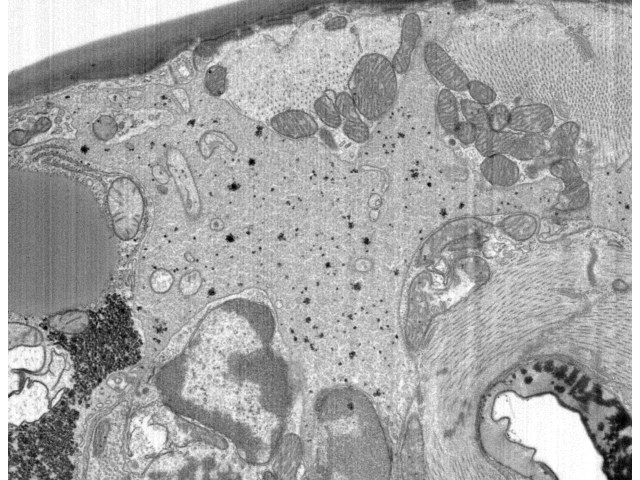

In [3]:
raw_image = 65535 - imread(os.path.join(tinfo.data_path, tinfo.image_file))
imshow(raw_image)

Run de-striping method

scale 0 start prediction - 0 mins 1.45 secs
detecting 336141 objects - 0 mins 4.09 secs
predict bands 0 total time - 0 mins 48.80 secs
scale 0 total time - 1 mins 2.75 secs
scale 1 start prediction - 0 mins 1.88 secs
detecting 232675 objects - 0 mins 4.73 secs
predict bands 1 total time - 0 mins 50.13 secs
scale 1 total time - 1 mins 4.37 secs
scale 2 start prediction - 0 mins 2.48 secs
detecting 45573 objects - 0 mins 3.92 secs
predict bands 2 total time - 0 mins 17.42 secs
scale 2 total time - 0 mins 31.95 secs
scale 3 start prediction - 0 mins 3.63 secs
detecting 9886 objects - 0 mins 4.75 secs
predict bands 3 total time - 0 mins 9.08 secs
scale 3 total time - 0 mins 26.98 secs
scale 4 start prediction - 0 mins 6.86 secs
detecting 2609 objects - 0 mins 7.91 secs
predict bands 4 total time - 0 mins 9.54 secs
scale 4 total time - 0 mins 53.68 secs
scale 5 start prediction - 0 mins 13.55 secs
detecting 847 objects - 0 mins 14.58 secs
predict bands 5 total time - 0 mins 15.40 secs
scale

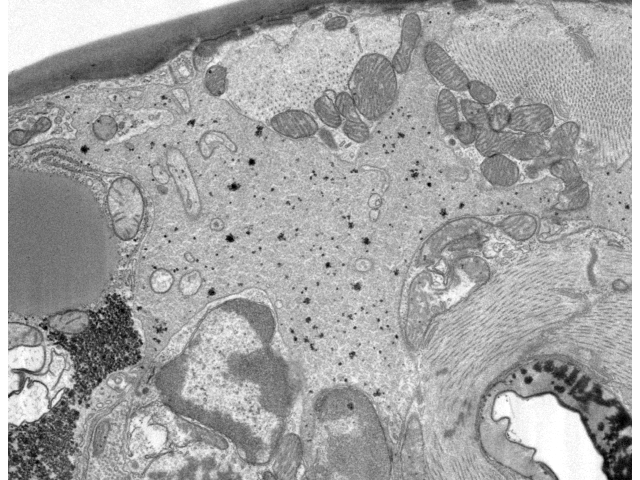

In [4]:
dbnd_image = run_deband(raw_image, direction = "vertical", scales = 6, adjust_beta = True,
                        details = {"start" : 2.1, "end" : 1.5, "middle" : 0.6, "mul" : 20, "len" : 187 },
                        destripe = [{ "method" : "predict", "bands_len" : 161, "mask_len" :  5, "max_angle" : 4.8, "max_ratio" : 0.3, "thresh_mul" : 1.67 },
                                    { "method" : "predict", "bands_len" : 161, "mask_len" :  9, "max_angle" : 4.8, "max_ratio" : 0.3 },
                                    { "method" : "predict", "bands_len" : 161, "mask_len" : 13, "max_angle" : 4.8, "max_ratio" : 0.3 },
                                    { "method" : "predict", "bands_len" : 201, "mask_len" : 19, "max_angle" : 4.8, "max_ratio" : 0.3 },
                                    { "method" : "predict", "bands_len" : 251, "mask_len" : 43, "max_angle" : 4.8, "max_ratio" : 0.3 },
                                    { "method" : "predict", "bands_len" : 301, "mask_len" : 75, "max_angle" : 4.8, "max_ratio" : 0.3 }],
                        verbose = True)
imshow(dbnd_image)

To adjust section intensity and correct the background, use the provided files `info.h5` and `polymodel.h5`. These files contain externally calculated information for the entire stack, and the methodology described in our article explains the process in detail. Please note that this package does not include code for calculating the correction information; we only provide the code for applying the externally calculated information to individual sections of the image. Computational operations on a cluster, which are required for creation of `info.h5` and `polymodel.h5` are not covered by this package.

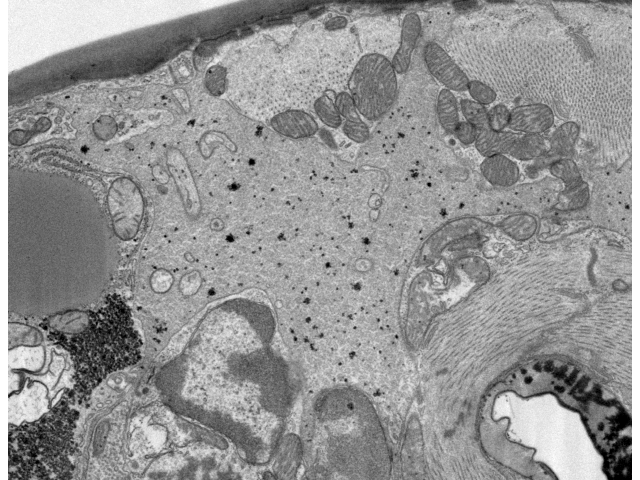

In [5]:
# correct intensity and background

tinfo.polymodel = load_polymodel(os.path.join(tinfo.data_path, "polymodel.h5"))
with h5py.File(os.path.join(tinfo.data_path, "info.h5"), mode = "r") as hfile:
    tinfo.intensity_correct = hfile["offset"][tinfo.section_idx]

corr_image, bwflat = correct_section_background(dbnd_image, 
                                                tinfo.shape, 
                                                intensity_shift = tinfo.intensity_correct,
                                                polymodel = tinfo.polymodel, 
                                                pos = (tinfo.section_idx, 0, 0))
imshow(corr_image)

The next step is to run denoising and contrast adjustment methods to generate the final image. The final image is stretched to utilize the full target intensity range (0-255).

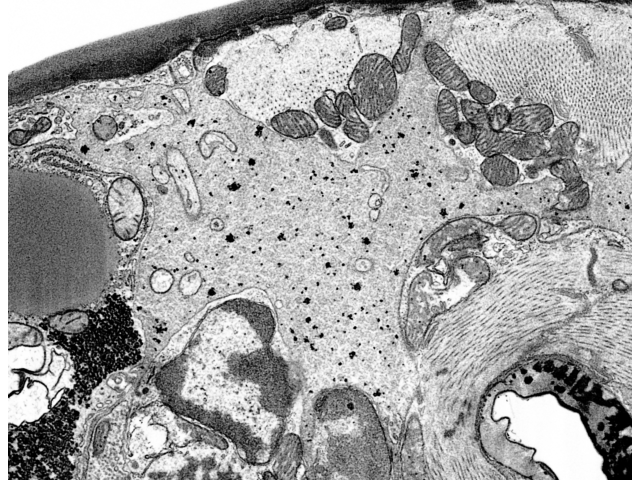

In [6]:
# denoise and contrast adjustment
import warnings
# Filter out the specific warning
warnings.filterwarnings("ignore", category=RuntimeWarning, message="overflow encountered in exp")

dnse_image = run_denoise(corr_image, 
                         sigmoid_params = [{"gain": 3.418e-6, "offset": -1.123}, 
                                           {"gain": 4.114e-6, "offset": 4.394}],
                         ndims = None, scales = 1, wsize = 7, split_hipass = True, propagate_noise = True)

final_image = adjust_histogram(dnse_image, drange = 255, dtype = np.uint8, bwmask = None, smoothing = 501,
                               method = "image", sigma = 2000.0, offset = -2000.0, ratio = 2, minmax_size = 5,
                               clip = [-0.8, 0.8], redistribute = "leftmost", hp_sigma = 1250,
                               mean = 28000, save_memory = True)
imshow(final_image, None)